## Topic Segmentation

### Fetching and preprocessing tweets

In [1]:
# Add project path to the PYTHONPATH

import os
import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [2]:
from nlp.dataset import Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matheus/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
filename = '../datasets/topic_segmentation/1183377763962671104-1182934217849749505_nobel.csv'
dataset = Dataset(filename, label_col='label', text_col='text')
dataset.load()
dataset.preprocess_texts(stemming=True, no_emoji=True)

Time to clean up: 3.29 sec


In [4]:
df = dataset.dataframe
df.cleaned.head()

0    pm abiy ahmed not exercising power control dis...
1                            cares fact received nobel
2    lithium ion batteries work earns nobel prize c...
3    congratulations nobel committee gave literatur...
4                 wow know obama nobel peace prize win
Name: cleaned, dtype: object

In [20]:
preprocessed_tweets = [tweet.split() for tweet in df.cleaned]
preprocessed_tweets[1:2]

[['cares', 'fact', 'received', 'nobel']]

In [21]:
%%time
dictionary = gensim.corpora.Dictionary(processed_tweets)
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
bow_corpus = [dictionary.doc2bow(tweets) for tweets in processed_tweets]

CPU times: user 255 ms, sys: 81 µs, total: 255 ms
Wall time: 253 ms


In [22]:
document_num = 0
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 0 ("ahmed") appears 1 time.
Word 1 ("control") appears 1 time.
Word 2 ("democracy") appears 1 time.
Word 3 ("like") appears 1 time.
Word 4 ("party") appears 1 time.
Word 5 ("pm") appears 1 time.
Word 6 ("power") appears 1 time.
Word 7 ("san") appears 1 time.
Word 8 ("winner") appears 1 time.


### Coherence model

In [28]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

In [107]:
%%time
num_topics_values = range(4, 16)
models = []
coherence_values = {
    'u_mass': [],
    'c_v': [],
    'c_uci': [],
    'c_npmi': []
}

for num_topics in num_topics_values:
    model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=num_topics, 
                                       id2word=dictionary,                                    
                                       passes=10,
                                       workers=4)
    models.append(model)
        
    u_mass_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='u_mass')
    coherence_values['u_mass'].append(u_mass_coherence_model.get_coherence())

    c_v_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_v')
    coherence_values['c_v'].append(c_v_coherence_model.get_coherence())
    
    c_uci_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_uci')
    coherence_values['c_uci'].append(c_uci_coherence_model.get_coherence())
    
    c_npmi_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_npmi')
    coherence_values['c_npmi'].append(c_npmi_coherence_model.get_coherence())

CPU times: user 2min 50s, sys: 10.3 s, total: 3min
Wall time: 2min 57s


### Graph plotting

In [51]:
import matplotlib.pyplot as plt
import numpy as np

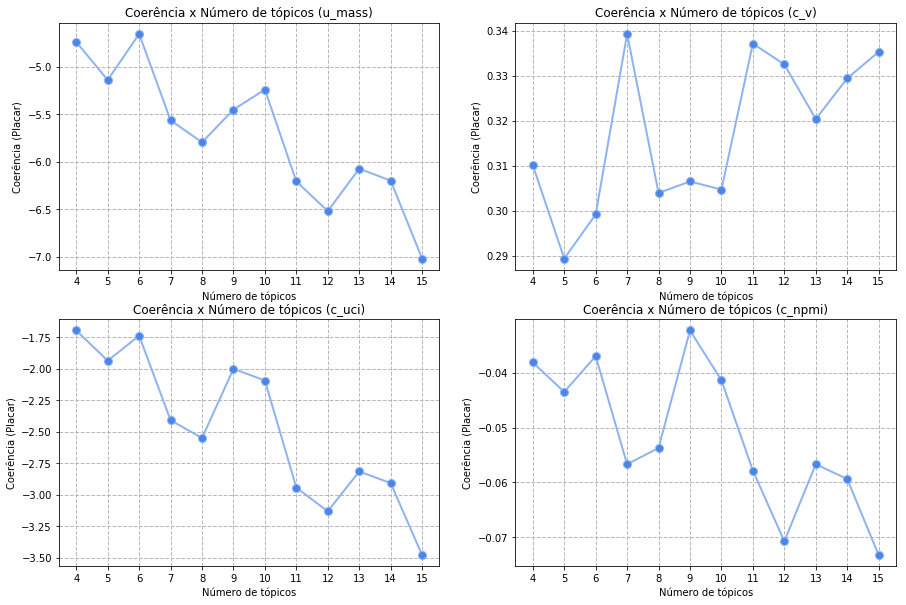

In [108]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['u_mass'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (u_mass)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,2)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_v'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_v)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,3)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_uci'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_uci)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,4)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_npmi'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_npmi)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 


plt.show() 

### Model visualization

In [26]:
import pyLDAvis.gensim

In [110]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(models[3], bow_corpus, dictionary, sort_topics=False)

/home/matheus/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.044940 -0.256374       1        1  11.485687
1     -0.106666 -0.031735       2        1  17.661146
2     -0.113798  0.021364       3        1  19.456512
3      0.305595  0.055441       4        1  14.333200
4     -0.081472  0.021968       5        1  11.687321
5     -0.008226  0.095163       6        1  11.687716
6     -0.040373  0.094174       7        1  13.688416, topic_info=     Category        Freq           Term       Total  loglift  logprob
0     Default  891.000000          ahmed  891.000000  30.0000  30.0000
139   Default  724.000000       ethiopia  724.000000  29.0000  29.0000
126   Default  593.000000          prime  593.000000  28.0000  28.0000
124   Default  569.000000       minister  569.000000  27.0000  27.0000
123   Default  575.000000      ethiopian  575.000000  26.0000  26.0000
47    Default  733.000000          greta  733.000000  25.0000  25.0000
369   Default  334.000000           wins  334.000000  24.0000  24.0000
5     Default  453.000000             pm  453.000000  23.0000  23.0000
302   Default  328.000000         handke  328.000000  22.0000  22.0000
49    Default  408.000000       thunberg  408.000000  21.0000  21.0000
23    Default  467.000000     literature  467.000000  20.0000  20.0000
38    Default  316.000000          peter  316.000000  19.0000  19.0000
56    Default  345.000000          first  345.000000  18.0000  18.0000
41    Default  258.000000      rejection  258.000000  17.0000  17.0000
138   Default  277.000000        eritrea  277.000000  16.0000  16.0000
19    Default  438.000000      committee  438.000000  15.0000  15.0000
25    Default  389.000000          obama  389.000000  14.0000  14.0000
816   Default  261.000000         africa  261.000000  13.0000  13.0000
75    Default  306.000000            got  306.000000  12.0000  12.0000
846   Default  277.000000          price  277.000000  11.0000  11.0000
178   Default  155.000000        physics  155.000000  10.0000  10.0000
44    Default  196.000000         letter  196.000000   9.0000   9.0000
1021  Default  124.000000          eliud  124.000000   8.0000   8.0000
14    Default  176.000000            ion  176.000000   7.0000   7.0000
518   Default  144.000000         prize:  144.000000   6.0000   6.0000
15    Default  178.000000        lithium  178.000000   5.0000   5.0000
267   Default  159.000000            ali  159.000000   4.0000   4.0000
13    Default  254.000000      chemistry  254.000000   3.0000   3.0000
183   Default  474.000000            via  474.000000   2.0000   2.0000
874   Default  143.000000        african  143.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
53     Topic7  106.531364       conflict  148.785492   1.6546  -4.5690
318    Topic7  100.926041         change  145.580688   1.6223  -4.6230
977    Topic7   49.913841         system   63.288475   1.7512  -5.3271
19     Topic7  238.366638      committee  438.728912   1.3785  -3.7636
6      Topic7   58.293785          power   76.973999   1.7106  -5.1719
109    Topic7  134.794968      president  247.350021   1.3816  -4.3337
255    Topic7   46.407017         norway   60.338272   1.7261  -5.4000
466    Topic7   37.344772         likely   45.348774   1.7944  -5.6172
245    Topic7   39.335804         within   49.672379   1.7553  -5.5653
148    Topic7  163.304932            one  542.483887   0.7881  -4.1418
45     Topic7   34.279125        perhaps   42.059235   1.7841  -5.7029
183    Topic7  140.948792            via  474.501190   0.7748  -4.2890
342    Topic7  140.655243           year  486.205658   0.7483  -4.2911
25     Topic7  121.913567          obama  389.731873   0.8265  -4.4341
8      Topic7  137.965347         winner  536.880798   0.6298  -4.3104
191    Topic7   95.531090          years  275.302948   0.9302  -4.6780
151    Topic7   58.289612  international  108.507202   1.3672  